# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** xx

**Author 1 (sciper):** Louis Le Guillouzic (xxxxx)  
**Author 2 (sciper):** Hugo Masson (xxxxx)   
**Author 3 (sciper):** Zhujing Zhang (xxxxx)   

**Release date:** 8.03.2023  
**Due date:** 24.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [16]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
print(data_base_path)
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

../data


---
## Part 1: Segmentation


### 1.0 Intro

In this exercise, you will be given two images. 

* `mucinous_adeno.jpg`: The image depicts a tissue sample from mucinous adenocarcinoma in colorectal cancer. The data is taken from the Cancer Genome Atlas (TCGA) which is an open-source database of different cancer types. Here you can see a tissue taken from a patient and stained using hematoxylin (purple) and eosin (pink) staining. The hematoxylin stains cell nuclei with a purplish blue, and the eosin stains the extracellular matrix and cytoplasm in pink.

* `mucinous_adeno_gt.jpg`: The second image is a coarse annotation of what is regarded as the so-called mucinous area. The mucinous area can be identified as a gray area tainted with purple. The presence of a large amount of mucin is a sign of a defect of normal epithelial cells that start to produce an unreasonable amount of mucin.


### 1.1 Tasks

You will be asked to extract the mucinous area using various approaches:

- [ ] Thresholding
- [ ] Morphology
- [ ] Region growing


### 1.1 Brain image visualization

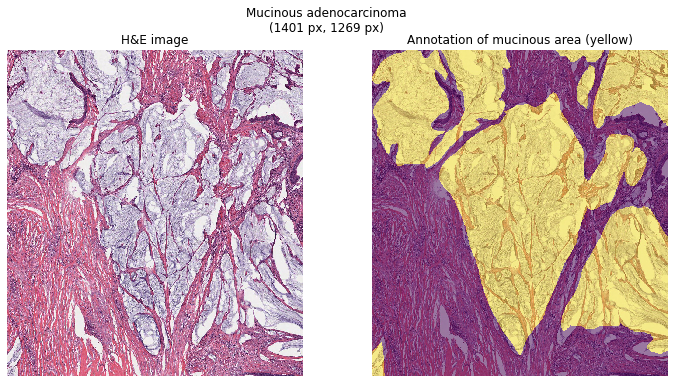

In [17]:
import skimage.io
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Load images
path_to_image = os.path.join(data_base_path, data_folder, "mucinous_adeno.jpg")
path_to_gt = os.path.join(data_base_path, data_folder, "mucinous_adeno_gt.jpg")
adeno_img = skimage.io.imread(path_to_image)
adeno_gt = skimage.io.imread(path_to_gt) > 128

# Get size of the image in px
im_h, im_w, im_c = adeno_img.shape

# Display MRI image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot image
ax[0].imshow(adeno_img, interpolation='nearest')
ax[0].set_title('H&E image'.format(im_h, im_w))
ax[0].axis('off')

# Plot image with overlay
ax[1].imshow(adeno_img, interpolation='nearest')
ax[1].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
ax[1].set_title('Annotation of mucinous area (yellow)')
ax[1].axis('off')
plt.suptitle("Mucinous adenocarcinoma\n({} px, {} px)".format(im_h, im_w))
plt.show()

---
### 1.2 Thresholding (4pts)
#### 1.2.1 RGB & Hue (1 pts)

Display the histogram for each channel (R, G, and B) as well as the histogram for the H (hue) channel. Note that you can use [rgb2hsv](https://scikit-image.org/docs/stable/api/skimage.color.html#skimage.color.rgb2hsv) to convert an RGB image to an HSV image and then extract the hue.

Text(0, 0.5, 'Pixel count')

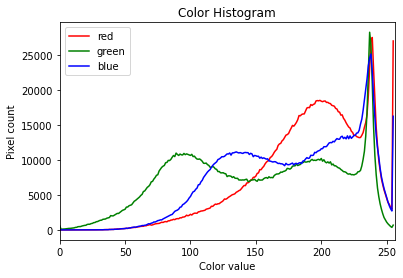

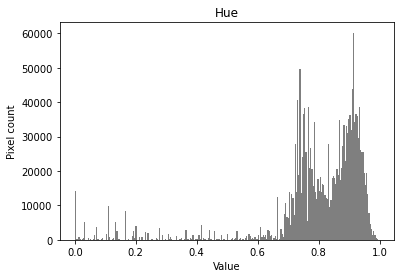

In [18]:
# to do
import matplotlib.pyplot as plt
import numpy as np

# tuple to select colors of each channel line
colors = ("red", "green", "blue")

# create the histogram plot, with three lines, one for
# each color
plt.figure()
plt.xlim([0, 256])
for channel_id, color in enumerate(colors):
    histogram, bin_edges = np.histogram(
        adeno_img[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=color, label=colors[channel_id])
plt.legend()
plt.title("Color Histogram")
plt.xlabel("Color value")
plt.ylabel("Pixel count")

#hue histogram

from skimage import color
adeno_hsv = color.rgb2hsv(adeno_img)
adeno_hue= adeno_hsv[...,0]

# pull out just the h channel
plt.figure()
lu=adeno_hsv[...,0].flatten()
plt.hist(lu,256,color='tab:grey')
plt.title("Hue")
plt.xlabel("Value")
plt.ylabel("Pixel count")

#### 1.2.2 Apply Thresholding (2 pts)

For each histogram find the threshold(s) that work the best to isolate the mucinous area. Display the image after thresholding of each channel as well as the error between your prediction ($im$) and the annotations ($gt$) using the formula:

$$error = 1 - \left( \frac{1}{IJ} \sum_{i,j} im_{i,j} == gt_{i, j} \right)$$

Here, I and J are the dimension of the image.

In [30]:
def calculate_error(mask,gt):
    return 1- np.sum(mask==gt) /mask.size

In [33]:
best_thresholds= [] #vector to stock the value of threshold

adeno_R = adeno_img[:,:,0]
adeno_G = adeno_img[:,:,1]
adeno_B = adeno_img[:,:,2]

#if we let adeno hue we find a value of threshold around 0.3 wchich is not coherent with our graph above. When we try to reverse the image, we find smth coherent

for image,name in zip([adeno_R, adeno_G, adeno_B, 1-adeno_hue],["red","green","blue","H"]):
# Initialize the variables
    best_error = 1. #error of 1 --> perfect 
    best_th = 0. 
    if name == "H":
        ths = np.linspace(0,1,256)
    else: 
        ths = range(256)
    
#find the threshold the makes the most difference
    for th in ths:
        image_mask = image>th #masking
        
        error = calculate_error(image_mask,adeno_gt)
        if error < best_error: #actualise if we find smth better
            best_th=th
            best_error=error
            
# Save the best threshold
    best_thresholds.append(best_th) #append --> add a value at the end of the vector
    
    
    if name=="H" : print(F"The threshold for the Hue: {best_th:0.4} with an error of {best_error : 0.3}")
    else : print(F"The threshold for the {name} channel: {best_th} with an error of {best_error : 0.4}")

The threshold for the red channel: 193 with an error of  0.448
The threshold for the green channel: 145 with an error of  0.2621
The threshold for the blue channel: 177 with an error of  0.2738
The threshold for the Hue: 0.1647 with an error of  0.199


Text(0.5, 1.0, 'Hue channel, error of 0.199')

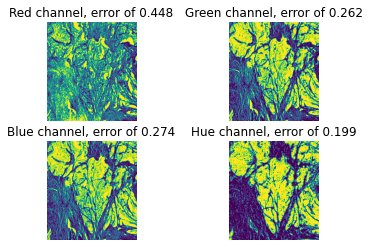

In [35]:
fig,ax =plt.subplots(2,2)

mask_treshold_R = adeno_R > best_thresholds[0]
ax[0,0].axis("off")
ax[0,0].imshow(mask_treshold_R)
error = calculate_error(mask_treshold_R,adeno_gt)
ax[0,0].set_title(F"Red channel, error of {error:0.3}")

mask_treshold_G = adeno_G > best_thresholds[1]
ax[0,1].axis("off")
ax[0,1].imshow(mask_treshold_G)
error = calculate_error(mask_treshold_G,adeno_gt)
ax[0,1].set_title(F"Green channel, error of {error:0.3}")

mask_treshold_B = adeno_B > best_thresholds[2]
ax[1,0].axis("off")
ax[1,0].imshow(mask_treshold_B)
error = calculate_error(mask_treshold_B,adeno_gt)
ax[1,0].set_title(F"Blue channel, error of {error:0.3}")

mask_treshold_hue = 1-adeno_hue > best_thresholds[3]
ax[1,1].axis("off")
ax[1,1].imshow(mask_treshold_hue)
error = calculate_error(mask_treshold_hue,adeno_gt)
ax[1,1].set_title(F"Hue channel, error of {error:0.3}")

#### 1.2.3 Best Thresholding (1 pts)

Based on your previous findings, set the best threshold(s) and create the final mask as the variable `mask_thesholding`

In [36]:
# TODO: replace variabel with your own threshod (1- hue)
mask_thesholding = mask_treshold_hue

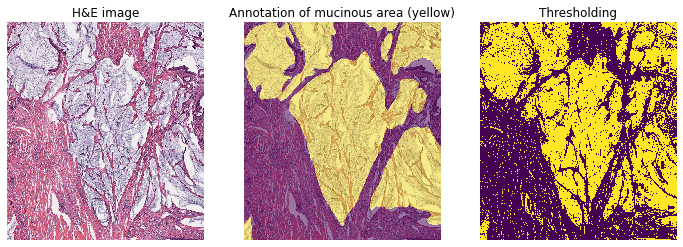

In [9]:
# Display MRI image
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# Plot image
ax[0].imshow(adeno_img, interpolation='nearest')
ax[0].set_title('H&E image'.format(im_h, im_w))
ax[0].axis('off')

ax[1].imshow(adeno_img, interpolation='nearest')
ax[1].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
ax[1].set_title('Annotation of mucinous area (yellow)')
ax[1].axis('off')

ax[2].imshow(mask_thesholding, interpolation='nearest')
ax[2].imshow(mask_thesholding, alpha=0.5, interpolation='nearest')
ax[2].set_title('Thresholding')
ax[2].axis('off')

plt.show()

---

### 1.3 Morphology (5pts)

To proceed, use the best results of the previous model (namely `mask_thesholding`) as the starting point. In this exercise we will try to clean the mask using morphology.

* A (2pts): Try the following operation [closing](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.closing), [opening](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.opening) with [disk](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.disk) size of: $1, 2, 5, 10$. Comment on the quality of the results.

* B (2pts): Try the following operation [remove_small_holes](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.remove_small_holes), [remove_small_objects](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.remove_small_objects) with size of: $10, 50, 100, 500$. Comment on the quality of the results.

* C (1pts): Based on your previous results, can you find a combination of the functions that improve your results? Plot the best result along with the error rate. Save the mask as the variable `mask_morph`

In [8]:
# TODO C
mask_morph = np.zeros_like(adeno_gt)

---
### 1.4 Region growing (5pts)

In this exercise you will implement from scratch your own region growing algorithm. Choose one of the image channel (R/G/B/H) as the source image. You can use multiple seed point to achieve better results. Plot the best result along with the error rate. Save the mask as the variable `mask_region`.

In [9]:
# TODO
mask_region = np.zeros_like(adeno_gt)

---
### 1.5 Method comparison (1pt)

In this section we display the overall outputs. Please make sure that you create the variables `mask_thesholding`, `mask_morph`, and `mask_region` to properly display the output. Comment on the results and what you think would be the best approach.

In [10]:
# Add your comments here

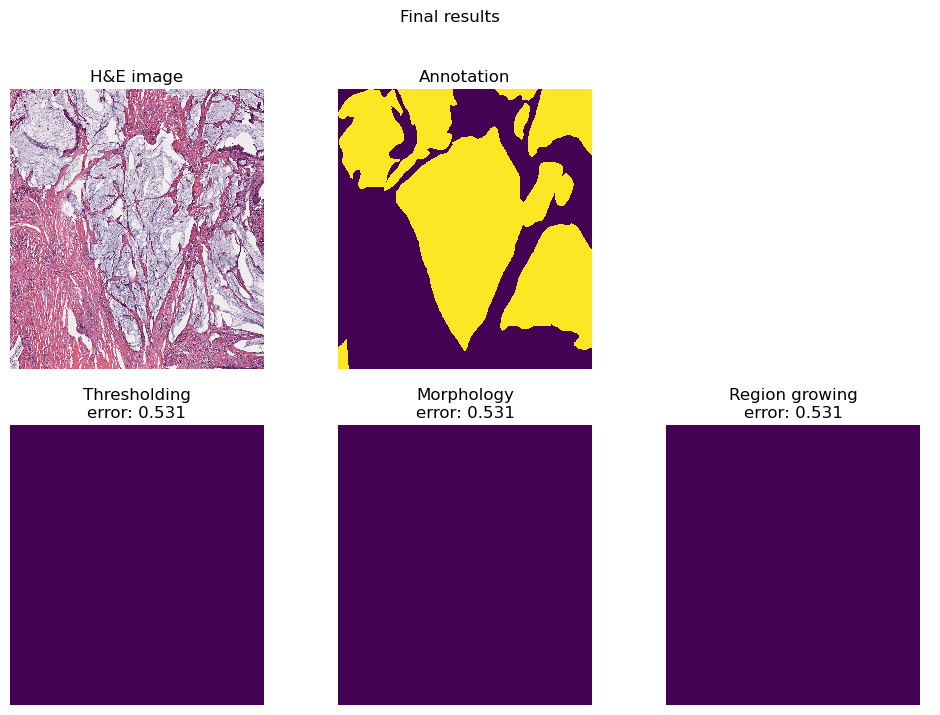

In [11]:
error_th = 1- (mask_thesholding == adeno_gt).mean()
error_morph = 1- (mask_morph == adeno_gt).mean()
error_region = 1- (mask_region == adeno_gt).mean()


# Display MRI image
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

# Plot image
ax[0, 0].imshow(adeno_img, interpolation='nearest')
ax[0, 0].set_title('H&E image'.format(im_h, im_w))

# Plot image with overlay
ax[0, 1].imshow(adeno_gt, interpolation='nearest')
ax[0, 1].set_title('Annotation')

# Plot estimation using thresholding
ax[1, 0].imshow(mask_thesholding, interpolation='nearest')
ax[1, 0].set_title('Thresholding\nerror: {:.3f}'.format(error_th))

# Plot estimation using Contour detection
ax[1, 1].imshow(mask_morph, interpolation='nearest')
ax[1, 1].set_title('Morphology\nerror: {:.3f}'.format(error_morph))


# Plot estimation using Region growing
ax[1, 2].imshow(mask_region, interpolation='nearest')
ax[1, 2].set_title('Region growing\nerror: {:.3f}'.format(error_region))


[a.axis('off') for a in ax.ravel()]


plt.suptitle("Final results")
plt.show()

# ---
## Part 2: Axon segmentations (10 points)

#### Intro 

Axon segmentation is vital to neuroscience research as it enables the study of neurons' morphology and connectivity. We will conduct two exercises to evaluate the impact of your segmentation algorithms under different independent artefacts. Each exercise consists of a synthetic **Ground Truth (GT)** and two more images simulating a specific artifact.

The **Ground Truth**  has tree main compartments. 1) The inner part of the axon. 2) The outer layer of the axon (called myelin) and the extracellular slace (the background of the image). 

The task consists into segmenting the three main compartments in the image to compute the inner-axon and outer-axon radii distribution.


To compute the radii, we suggest the following approximation.
$$\hat{r}_{I}= \sqrt{\frac{A_{yellow}}{\pi}}$$
$$\hat{r}_{O}= \sqrt{\frac{A_{yellow} + A_{blue}}{\pi}}$$
Where **A** is the corresponding area of the comparments. 
**Using this image as reference** 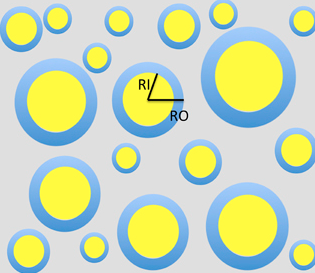

#### Artifacts simulated:

Excercise 1) Two images with different levels of SNR (signal to noise ratio). The images have rician noise.
Exercise  2) Two images adquired using a fraction of the fourier space. Only Lowest frequency are used to reconstruct the image. (simulating fast aquisitions in MRI)

Ensure your algorithm works on the GT before you go to the test cases with artifacts. Apply any preprocessing needed to the image. The preprocessing can be different for each type of image.

### Tasks

For each exercise we ask to:

1) Segment the images with the following colors: blue the inner part of the axon, red the outer part of the axon (myelin) and white for the backround(example) 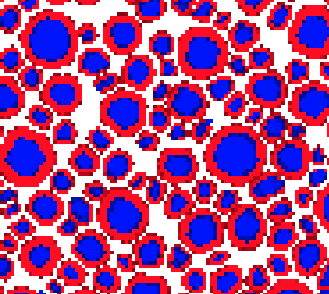

2) Count the number of axons obtained in the sample, calculate the radii for each axons, and display a radii histogram for the each of the images(GT and test cases).

In the exercises, assume that each pixel side is $(0.1 \mu m)$, i.e. a pixel has an area of $(0.01 \mu m^2 )$

## Grading 
The answers does not have to be perfect, they just be a good approximation.

1. Developing an algorithm that works for the two GT images. **(3 points)** 
2. Use preprosesing to prepare the images with SNR and the Low frequencies.  (**1 point** for SNR preprocesing , **1 point** for Low-frequency images preprocesing)
3. Running the algorithm in the test images. **1/2 point** SNR, **1/2 point** Low freqs
4. Computing and plotting radii distributions **(1 point)**
5. Explaining and discussing your implementation. **(3 points )**
    Try to be specific, not necessarily long. In the discussion include:
 1. What worked? 
 2. What did not work?
 3. Why do you think it does not work? 
 4. How could you improve your algorithms as future work?  Try to avoid general comments like "using deep learning" 
 
**Extra points: Real data example (3 points), the algorithm should display a _good enough_ segmentation.**

### 2.1 SNR

In [12]:
data_base_path

'..\\data'

In [13]:
#remplacer cv2 par commande d'en haut pour importer des images

import cv2
import matplotlib.pyplot as plt

data_base_path = os.path.join(os.pardir, 'data')
print(data_base_path)
data_folder = 'lab-01-data'

path_folder = os.path.join(data_base_path, data_folder) + '/' 

files = ["GT_0.png"  , "test_0_0.png" , "test_0_1.png"]
gt_0 = cv2.imread(path_folder+ files[0])
snr_10 = cv2.imread(path_folder+ files[1])
snr_3 = cv2.imread(path_folder+ files[2])

images = [gt_0 , snr_10, snr_3]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(24, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

ModuleNotFoundError: No module named 'cv2'

### 2.1.1 Preprocessing 

 % add your images after preprocessing



### 2.1.2 Results Segmetations

In [ ]:
images = [gt_0 , snr_10, snr_3]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(255- im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.1.3 Radii histrograms 

In [ ]:
## results Radii distribution. proposal feel free to change it
import numpy as np


rads_outer = np.random.normal(0, 1, 200)
rads_inner = np.random.normal(0, 1, 200)


rads_gt = [ rads_inner ,rads_outer]
rads_test0 = [ rads_inner ,rads_outer]  # your result
rads_test1 = [ rads_inner ,rads_outer]  # your result

all_rads= [rads_gt , rads_test0 , rads_test1] 

images = [gt_0 , snr_10, snr_3]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, rads, nm in zip(axes.ravel(), all_rads, im_names):
    ax.hist(rads[0]  , color = "red" , label = "inner" ,alpha= 0.5)
    ax.hist(rads[1]  , color = "blue" , label = "outer" ,alpha= 0.5)
    ax.legend()
    ax.set_title(nm)
plt.show()


### 2.2 Low frequencies

In [ ]:

files = ["GT_3.png"  , "test_3_0.png" , "test_3_1.png"]
path = "data/"
gt_3 = cv2.imread(path_folder+ files[0])
lowfreq0 = cv2.imread(path_folder+ files[1])
lowfreq1 = cv2.imread(path_folder+ files[2])

images = [gt_3 , lowfreq0, lowfreq1]
im_names = ["GT" , "Low " , "Lower"]
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2.1 Preprocessing

### 2.2.2 Results Segmetations

### 2.2.3 Radii histrograms


### 2.5 Not mandatory exercise, Real data ( 3 points )

The points are given just by having a good enough segmentation.

In [ ]:
# Add your implementation and discussion
import cv2

files = ["extra_point.png" ]
real_data = cv2.imread(path_folder+ files[0])

plt.imshow(real_data[:256, :256])